# Mixture Density Networks

Mixture density networks (MDN) (Bishop, 1994) are a class
of models obtained by combining a conventional neural network with a
mixture density model.

In [ ]:
!pip install tensorflow==1.14.0
!pip install tensorflow-probability==0.7.0
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import warnings

from tensorflow_probability import edward2 as ed
from scipy import stats
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

In [3]:
def plot_normal_mix(pis, mus, sigmas, ax, label='', comp=True):
    """Plots the mixture of Normal models to axis=ax comp=True plots all
    components of mixture model
    """
    x = np.linspace(-10.5, 10.5, 250)
    final = np.zeros_like(x)
    for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
        temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
        final = final + temp
        if comp:
            ax.plot(x, temp, label='Normal ' + str(i))
    ax.plot(x, final, label='Mixture of Normals ' + label)
    ax.legend(fontsize=13)


def sample_from_mixture(x, pred_weights, pred_means, pred_std, amount):
    """Draws samples from mixture model.

    Returns 2 d array with input X and sample from prediction of mixture model.
    """
    samples = np.zeros((amount, 2))
    n_mix = len(pred_weights[0])
    to_choose_from = np.arange(n_mix)
    for j, (weights, means, std_devs) in enumerate(
                    zip(pred_weights, pred_means, pred_std)):
        index = np.random.choice(to_choose_from, p=weights)
        samples[j, 1] = np.random.normal(means[index], std_devs[index], size=1)
        samples[j, 0] = x[j]
        if j == amount - 1:
            break
    return samples

## Data

We use the same toy data from
[David Ha's blog post](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/), where he explains MDNs. It is an inverse problem where
for every input $x_n$ there are multiple outputs $y_n$.

Size of features in training data: (5000, 1)
Size of output in training data: (5000,)
Size of features in test data: (5000, 1)
Size of output in test data: (5000,)


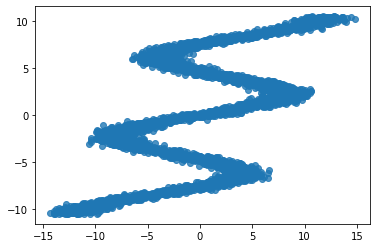

In [4]:
def build_toy_dataset(N):
    y_data = np.random.uniform(-10.5, 10.5, N).astype(np.float32)
    r_data = np.random.normal(size=N).astype(np.float32)    # random noise
    x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
    x_data = x_data.reshape((N, 1))
    return x_data, y_data

import random 

tf.random.set_random_seed(42)
np.random.seed(42)
random.seed(42)

#inf.setseed(42)

N = 5000    # number of data points
D = 1    # number of features
K = 20    # number of mixture components

X_train, y_train = build_toy_dataset(N)
X_test, y_test = build_toy_dataset(N)

print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))
sns.regplot(X_train, y_train, fit_reg=False)
plt.show()

## Fitting a Neural Network

We could try to fit a neural network over this data set. However, in this data set for each x value there are multiple y values. So, things do not work as should be using standard neural networks.

Let's define first the neural network. We use `tf.keras.layers` to construct neural networks. We specify a three-layer network with 15 hidden units for each hidden layer.

In [12]:
def neural_network(X):
    # 2 hidden layers with 15 hidden units
    h0 = tf.keras.layers.Dense(15, activation=tf.nn.relu)
    h1 = tf.keras.layers.Dense(15, activation=tf.nn.relu)
    h2 = tf.keras.layers.Dense(1, activation=None)
    return h2(h1(h0(X)))

Let's now try to fit the neural network to the data

618603260.0
463264200.0
462376200.0
462355700.0
462345660.0
462341060.0
462339300.0
462338530.0
462338300.0
462338240.0


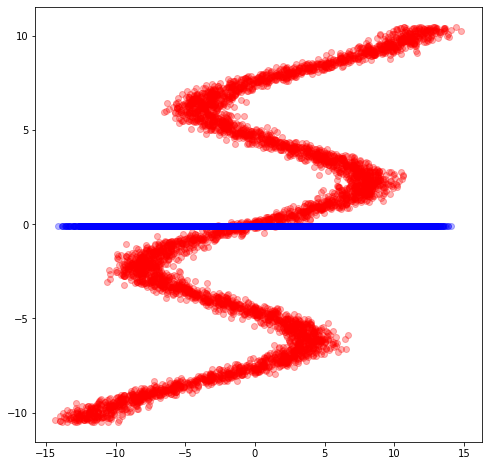

In [13]:
x = tf.placeholder(dtype=tf.float32, shape=[None,1])
y = tf.placeholder(dtype=tf.float32, shape=[None])

y_out = neural_network(x)

lossfunc = tf.nn.l2_loss(y_out-y);

train_op = tf.train.AdamOptimizer(learning_rate=0.1).minimize(lossfunc)

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

NEPOCH = 100
for i in range(NEPOCH):
    sess.run(train_op,feed_dict={x: X_train, y: y_train})
    if i%10==0:
                print(sess.run(lossfunc,feed_dict={x: X_train, y: y_train}))    

y_test = sess.run(y_out,feed_dict={x: X_test})

plt.figure(figsize=(8, 8))
plt.plot(X_train,y_train,'ro',X_test,y_test,'bo',alpha=0.3)
plt.show()

sess.close()

As can be seen, the neural network is not able to fit this data set

## Mixture Density Network (MDN)

We use a MDN with a mixture of 20 normal distributions parameterized by a
feedforward network. That is, the membership probabilities and
per-component mean and standard deviation are given by the output of a
feedforward network.


We define our probabilistic model using [Edward2](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/python/experimental/edward2) constructs. Specifically, we use the `MixtureSameFamily` distribution, where the the parameters of this network are provided by our feedforwrad network.

In [7]:
def make_neural_network():
    """loc, scale, logits = NN(x; theta)"""
    # 2 hidden layers with 15 hidden units
    h0 = tf.keras.layers.Dense(15, activation=tf.nn.relu)
    h1 = tf.keras.layers.Dense(15, activation=tf.nn.relu)
    locs = tf.keras.layers.Dense(K, activation=None)
    scales = tf.keras.layers.Dense(K, activation=tf.exp)
    logits = tf.keras.layers.Dense(K, activation=None)
    
    def call(X):
        net = h1(h0(X))
        return locs(net), scales(net), logits(net) 
    
    return call


def mdn(N, neural_network):
        x = ed.Normal(loc = tf.ones([N,D]), scale = 1.0, name="x")
        locs, scales, logits = neural_network(x)
        y = ed.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=logits), components_distribution=tfp.distributions.Normal(loc=locs, scale=scales+0.01), name="y")
        return x,y

Note that we use the `MixtureSameFamily` random variable. It collapses
out the membership assignments for each data point and makes the model
differentiable with respect to all its parameters. It takes a
`Categorical` random variable as input—denoting the probability for each
cluster assignment—as well as `components`, which is a list of
individual distributions to mix over.

For more background on MDNs, take a look at
[Christopher Bonnett's blog post](http://cbonnett.github.io/MDN.html) or at Bishop (1994).

## Inference

We train the MDN model. For details, see the documentation about
[Edward2](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/python/experimental/edward2).

In [8]:
neural_network = make_neural_network()

x,y=mdn(N, neural_network)

with ed.interception(ed.make_value_setter(x=X_train,y=y_train)):
        px,py = mdn(N,neural_network)

energy =    tf.reduce_sum(py.distribution.log_prob(py.value))

entropy = 0

elbo = energy - entropy

num_epochs=5000
verbose=True
sess = tf.Session()
optimizer = tf.train.AdamOptimizer(0.01)
t = []
train = optimizer.minimize(-elbo)
init = tf.global_variables_initializer()

sess.run(init)

for i in range(num_epochs+1):
        t.append(sess.run(elbo))
        sess.run(train)
        if verbose:
                if i % 10 == 0: print(".", end="", flush=True)
                if i % 100 == 0:
                        str_elbo = str(-t[-1])
                        print("\n" + str(i) + " epochs\t" + str_elbo, end="", flush=True)



W0916 11:35:05.780528 4478059968 deprecation.py:323] From /Users/rcabanas/venv/deep_prob_modeling/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:2403: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


.
0 epochs	41061.402..........
100 epochs	10533.76..........
200 epochs	7175.426..........
300 epochs	6791.1597..........
400 epochs	6681.819..........
500 epochs	6657.986..........
600 epochs	6615.552..........
700 epochs	6584.221..........
800 epochs	6570.326..........
900 epochs	6566.966..........
1000 epochs	6571.029..........
1100 epochs	6631.9707..........
1200 epochs	6616.0347..........
1300 epochs	6557.4473..........
1400 epochs	6567.6426..........
1500 epochs	6530.532..........
1600 epochs	6612.218..........
1700 epochs	6523.9434..........
1800 epochs	6540.269..........
1900 epochs	6598.717..........
2000 epochs	6518.84..........
2100 epochs	6553.381..........
2200 epochs	6525.708..........
2300 epochs	6531.082..........
2400 epochs	6531.699..........
2500 epochs	6756.7744..........
2600 epochs	6525.0376..........
2700 epochs	6513.5776..........
2800 epochs	6520.1094..........
2900 epochs	6523.233..........
3000 epochs	6529.7393..........
3100 epochs	6511.2446..........
3200 e

After training, we can now see how the same network embbeded in a mixture model is able to perfectly capture the training data.

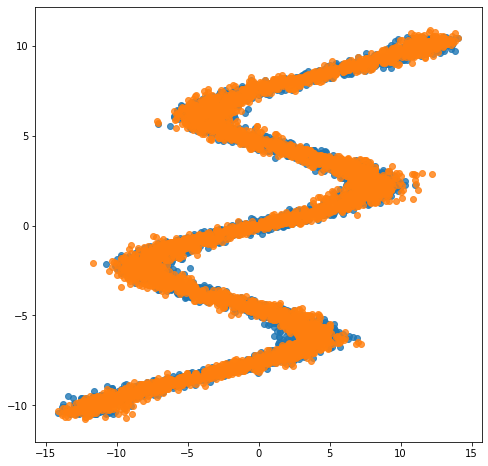

In [9]:
X_test, y_test = build_toy_dataset(N)

with ed.interception(ed.make_value_setter(x=X_test)):
        px,py = mdn(N, neural_network)

y_pred = sess.run(py)

plt.figure(figsize=(8, 8))
sns.regplot(X_test, y_test, fit_reg=False)
sns.regplot(X_test, y_pred, fit_reg=False)
plt.show()

## Acknowledgments

This tutorial is inspired by [David Ha's blog post](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/) and [Edward's tutorial](http://edwardlib.org/tutorials/mixture-density-network).